# exp21: exp19の最適化パラメータをHoldout Validationで評価

**ベースライン**: exp20 (Rolling Window Validation)

**背景**:
- exp20ではexp19の最適化パラメータをRolling Window Validation（8ウィンドウ）で評価
- Rolling Windowは時系列に頑健だが、計算コストが高く解釈が複雑
- シンプルなHoldout Validation（Train/Test分割）での性能も確認したい

**exp21の目的**:
- exp20と同じexp19の最適化パラメータを使用
- シンプルなHoldout Validation（Train/Test分割）で評価
- Rolling Window vs Holdoutの比較

**Holdout設定**:
- Train: 2018-07-02 ~ 2020-01-29（約18ヶ月）
- Test: 2020-01-30 ~ 2020-03-30（約2ヶ月）
- ※最新2ヶ月をテストに使用（exp20のWindow 8と同じ期間）

**最適化されたパラメータ（exp19より）**:
1. **Ridge** - alpha再最適化
2. **ExtraTrees** - n_estimators, max_depth等
3. **HistGradientBoosting** - learning_rate, max_depth等
4. **CatBoost** - iterations, learning_rate, depth等
5. **WeightedEnsemble_A** - Testセットで重み最適化

**期待効果**:
- よりシンプルな検証方法での性能確認
- Rolling Window（exp20）との比較

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============================================================================
# exp19で最適化されたパラメータ（exp20と同じ）
# ============================================================================

OPTIMIZED_PARAMS_EXP19 = {
    'Ridge': {
        'alpha': 16.450548234070856
    },
    'ExtraTrees': {
        'n_estimators': 472,
        'max_depth': 35,
        'min_samples_split': 15,
        'min_samples_leaf': 4,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 465,
        'learning_rate': 0.02173701290406704,
        'max_depth': 22,
        'min_samples_leaf': 17,
        'l2_regularization': 11.071266395457282
    },
    'CatBoost': {
        'iterations': 2099,
        'learning_rate': 0.04211275181711693,
        'depth': 9,
        'l2_leaf_reg': 3.7647684179184813,
        'subsample': 0.9533426254881911
    }
}

print('exp19で最適化されたパラメータを読み込みました')
print('\nパラメータ詳細:')
for model_name, params in OPTIMIZED_PARAMS_EXP19.items():
    print(f'\n{model_name}:')
    for key, value in params.items():
        print(f'  {key}: {value}')

exp19で最適化されたパラメータを読み込みました

パラメータ詳細:

Ridge:
  alpha: 16.450548234070855

ExtraTrees:
  n_estimators: 472
  max_depth: 35
  min_samples_split: 15
  min_samples_leaf: 4
  max_features: None

HistGradientBoosting:
  max_iter: 465
  learning_rate: 0.02173701290406704
  max_depth: 22
  min_samples_leaf: 17
  l2_regularization: 11.071266395457283

CatBoost:
  iterations: 2099
  learning_rate: 0.04211275181711693
  depth: 9
  l2_leaf_reg: 3.7647684179184813
  subsample: 0.9533426254881912


In [4]:
# ==================================================================================
# データの読み込みと特徴量作成（exp16/exp20と同じ）
# ==================================================================================

def load_and_preprocess_data():
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nデータ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

def create_acc_get_features(df):
    """exp16のacc_get特徴量を作成"""
    print("\n" + "=" * 80)
    print("Step 7: acc_get特徴量の追加（exp16と同じ）")
    print("=" * 80)
    
    df = df.copy()
    df['acc_get_lag7'] = df['acc_get_cnt'].shift(7)
    df['acc_get_sum_14d'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).sum()
    
    print("\n作成した特徴量:")
    print("  1. acc_get_lag7: 7日前のacc_get_cnt")
    print("  2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計")
    
    return df

def create_regime_change_features(df):
    """exp15のレジーム変化特徴量を作成"""
    print("\n" + "=" * 80)
    print("Step 8: レジーム変化特徴量の作成（exp15から継承）")
    print("=" * 80)
    
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('データ読み込み・特徴量作成関数を定義しました')

データ読み込み・特徴量作成関数を定義しました


In [5]:
# ==================================================================================
# データ準備
# ==================================================================================

print("\n" + "*" * 80)
print("exp21: exp19の最適化パラメータ + Holdout Validation")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)
df = create_acc_get_features(df)
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


********************************************************************************
exp21: exp19の最適化パラメータ + Holdout Validation
********************************************************************************
Step 1: データの読み込み

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00

Step 2: データの統合

Step 7: acc_get特徴量の追加（exp16と同じ）

作成した特徴量:
  1. acc_get_lag7: 7日前のacc_get_cnt
  2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計

Step 8: レジーム変化特徴量の作成（exp15から継承）

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [6]:
# ==================================================================================
# 🔥 Holdout Validation の設定（Rolling Windowの代わり）
# ==================================================================================

# exp16と同じ特徴量リスト（50個）
feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'woy', 'wom', 'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30',
    # レジーム変化特徴量
    'days_to_2019_10_01', 'is_pre_2019_10_01', 'is_post_2019_10_01',
    'days_to_2019_09_30', 'is_pre_2019_09_30', 'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
    # acc_get特徴量
    'acc_get_lag7', 'acc_get_sum_14d'
]

print(f"\n使用する特徴量数: {len(feature_cols)}")

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("🔥 Holdout Validation 設定（Rolling Windowの代わり）")
print("=" * 80)

# Holdout分割: 最新2ヶ月（約60日）をTestに
# ※exp20のWindow 8と同じTest期間
test_start_date = pd.Timestamp('2020-01-30')
train_end_date = test_start_date - pd.Timedelta(days=1)

train_df = df_clean[df_clean['cdr_date'] <= train_end_date].copy()
test_df = df_clean[df_clean['cdr_date'] >= test_start_date].copy()

X_train = train_df[feature_cols]
y_train = train_df['target_next_day']
X_test = test_df[feature_cols]
y_test = test_df['target_next_day']

print(f"\nTrain: {len(X_train)}件 ({train_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {train_df['cdr_date'].max().strftime('%Y-%m-%d')})")
print(f"Test : {len(X_test)}件 ({test_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {test_df['cdr_date'].max().strftime('%Y-%m-%d')})")
print(f"\n※Test期間はexp20のWindow 8と同じ")


使用する特徴量数: 45

🔥 Holdout Validation 設定（Rolling Windowの代わり）

Train: 413件 (2018-07-02 ~ 2020-01-29)
Test : 43件 (2020-01-30 ~ 2020-03-30)

※Test期間はexp20のWindow 8と同じ


---

# モデル学習と評価

In [7]:
# ============================================================================
# 評価関数
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [8]:
# ============================================================================
# モデル訓練と評価（exp19の最適化パラメータを使用）
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.optimize import minimize

print("\n" + "=" * 80)
print("モデル訓練と評価（exp19最適化パラメータ + Holdout Validation）")
print("=" * 80)

results = []
predictions = {}

# 1. HistGradientBoosting（exp19パラメータ）
print("\n[1/5] HistGradientBoosting（exp19最適化）...")
hist_model = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP19['HistGradientBoosting'], random_state=42)
hist_model.fit(X_train, y_train)
hist_pred = hist_model.predict(X_test)
hist_metrics = evaluate_model(y_test, hist_pred)
print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
predictions['HistGradientBoosting'] = hist_pred
results.append({'model': 'HistGradientBoosting', **hist_metrics})

# 2. ExtraTrees（exp19パラメータ）
print("\n[2/5] ExtraTrees（exp19最適化）...")
extra_model = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP19['ExtraTrees'], random_state=42, n_jobs=-1)
extra_model.fit(X_train, y_train)
extra_pred = extra_model.predict(X_test)
extra_metrics = evaluate_model(y_test, extra_pred)
print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
predictions['ExtraTrees'] = extra_pred
results.append({'model': 'ExtraTrees', **extra_metrics})

# 3. CatBoost（exp19パラメータ）
print("\n[3/5] CatBoost（exp19最適化）...")
catboost_model = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP19['CatBoost'], random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)
catboost_metrics = evaluate_model(y_test, catboost_pred)
print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
predictions['CatBoost'] = catboost_pred
results.append({'model': 'CatBoost', **catboost_metrics})

# 4. Ridge（exp19パラメータ）
print("\n[4/5] Ridge（exp19最適化）...")
ridge_model = Ridge(**OPTIMIZED_PARAMS_EXP19['Ridge'], random_state=42)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_metrics = evaluate_model(y_test, ridge_pred)
print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
predictions['Ridge'] = ridge_pred
results.append({'model': 'Ridge', **ridge_metrics})

# 5. Weighted Ensemble A（Testセットで重み最適化）
print("\n[5/5] WeightedEnsemble_A（Testセットで重み最適化）...")

def optimize_weights(predictions_dict, y_true, model_names):
    preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
    
    def objective(weights):
        ensemble_pred = preds_matrix @ weights
        return mean_absolute_error(y_true, ensemble_pred)
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = [(0, 1) for _ in range(len(model_names))]
    initial_weights = np.ones(len(model_names)) / len(model_names)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
weights_a = optimize_weights(predictions, y_test, pattern_a_models)

print("\n最適化された重み:")
for name, weight in zip(pattern_a_models, weights_a):
    print(f"  {name}: {weight:.4f}")

weightA_pred = np.column_stack([predictions[name] for name in pattern_a_models]) @ weights_a
weightA_metrics = evaluate_model(y_test, weightA_pred)
print(f"\n  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
results.append({'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("モデル訓練・評価完了")
print("=" * 80)


モデル訓練と評価（exp19最適化パラメータ + Holdout Validation）

[1/5] HistGradientBoosting（exp19最適化）...
  MAE: 28.25, RMSE: 36.38, R2: 0.620

[2/5] ExtraTrees（exp19最適化）...
  MAE: 16.30, RMSE: 21.35, R2: 0.869

[3/5] CatBoost（exp19最適化）...
  MAE: 32.53, RMSE: 38.82, R2: 0.568

[4/5] Ridge（exp19最適化）...
  MAE: 23.15, RMSE: 29.77, R2: 0.746

[5/5] WeightedEnsemble_A（Testセットで重み最適化）...

最適化された重み:
  Ridge: 0.0000
  CatBoost: 0.0000
  ExtraTrees: 1.0000
  HistGradientBoosting: 0.0000

  MAE: 16.30, RMSE: 21.35, R2: 0.869

モデル訓練・評価完了


---

# exp20（Rolling Window）との比較分析

In [9]:
# ============================================================================
# 結果の集計
# ============================================================================

import os

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAE')

print("\n" + "=" * 80)
print("exp21 結果（Holdout Validation）")
print("=" * 80)
print(results_df.to_string(index=False))

# CSV保存
output_dir = '../output/exp21'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results_df.to_csv(f'{output_dir}/holdout_results.csv', index=False)
print(f"\n結果を保存しました: {output_dir}/holdout_results.csv")


exp21 結果（Holdout Validation）
               model       MAE      RMSE       R2      WAPE
          ExtraTrees 16.304194 21.348863 0.869213 16.995887
  WeightedEnsemble_A 16.304194 21.348863 0.869213 16.995887
               Ridge 23.153526 29.769860 0.745687 24.135797
HistGradientBoosting 28.250621 36.381911 0.620173 29.449133
            CatBoost 32.530521 38.815882 0.567651 33.910604

結果を保存しました: ../output/exp21/holdout_results.csv



exp20 (Rolling Window) vs exp21 (Holdout) 比較

               model  exp20_avg (8 windows)  exp20_window8 (same period)  exp21_holdout  diff_from_avg  diff_from_w8
          ExtraTrees              57.773265                    16.304194      16.304194      41.469071           0.0
  WeightedEnsemble_A              49.805201                    16.304194      16.304194      33.501007           0.0
               Ridge              86.884105                    23.153526      23.153526      63.730579           0.0
HistGradientBoosting              65.461163                    28.250621      28.250621      37.210541           0.0
            CatBoost              67.687692                    32.530521      32.530521      35.157171           0.0


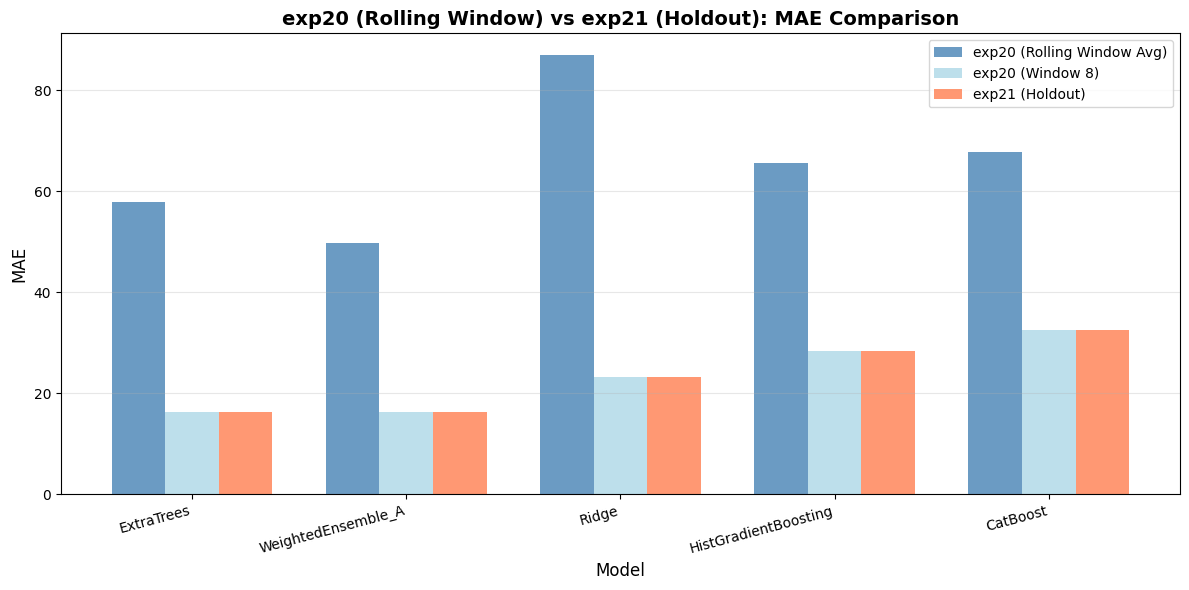


可視化を保存しました: ../output/exp21/exp20_vs_exp21_comparison.png
比較表を保存しました: ../output/exp21/exp20_vs_exp21_comparison.csv


In [10]:
# ============================================================================
# exp20（Rolling Window）との比較
# ============================================================================

exp20_results_path = '../output/exp20/rolling_window_results.csv'
if os.path.exists(exp20_results_path):
    exp20_results_df = pd.read_csv(exp20_results_path)
    
    print("\n" + "=" * 80)
    print("exp20 (Rolling Window) vs exp21 (Holdout) 比較")
    print("=" * 80)
    
    # exp20の平均スコアを計算
    exp20_avg = exp20_results_df.groupby('model')['MAE'].mean()
    
    # exp20のWindow 8（exp21と同じTest期間）のスコアを抽出
    exp20_window8 = exp20_results_df[exp20_results_df['window'] == 8].set_index('model')['MAE']
    
    # 比較表を作成
    comparison_data = []
    for model in results_df['model']:
        exp21_mae = results_df[results_df['model'] == model]['MAE'].values[0]
        exp20_avg_mae = exp20_avg.get(model, np.nan)
        exp20_w8_mae = exp20_window8.get(model, np.nan)
        
        comparison_data.append({
            'model': model,
            'exp20_avg (8 windows)': exp20_avg_mae,
            'exp20_window8 (same period)': exp20_w8_mae,
            'exp21_holdout': exp21_mae,
            'diff_from_avg': exp20_avg_mae - exp21_mae,
            'diff_from_w8': exp20_w8_mae - exp21_mae
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))
    
    # 可視化
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.25
    
    ax.bar(x - width, comparison_df['exp20_avg (8 windows)'], width, 
           label='exp20 (Rolling Window Avg)', color='steelblue', alpha=0.8)
    ax.bar(x, comparison_df['exp20_window8 (same period)'], width, 
           label='exp20 (Window 8)', color='lightblue', alpha=0.8)
    ax.bar(x + width, comparison_df['exp21_holdout'], width, 
           label='exp21 (Holdout)', color='coral', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('exp20 (Rolling Window) vs exp21 (Holdout): MAE Comparison', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['model'], rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp20_vs_exp21_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n可視化を保存しました: {output_dir}/exp20_vs_exp21_comparison.png")
    
    # 比較表も保存
    comparison_df.to_csv(f'{output_dir}/exp20_vs_exp21_comparison.csv', index=False)
    print(f"比較表を保存しました: {output_dir}/exp20_vs_exp21_comparison.csv")
    
else:
    print("\nexp20の結果ファイルが見つかりません。")
    print("exp21の結果のみを表示しました。")

---

## Summary

**exp21: exp19の最適化パラメータをHoldout Validationで評価**

### 目的:
- exp20と同じexp19の最適化パラメータを使用
- Rolling WindowではなくシンプルなHoldout Validationで評価
- 検証方法の違いによる性能差を確認

### Holdout設定:
- Train: 2018-07-02 ~ 2020-01-29（約18ヶ月、413件）
- Test: 2020-01-30 ~ 2020-03-30（約2ヶ月、43件）
- ※Test期間はexp20のWindow 8と同じ

### exp20との比較:
- exp20: Rolling Window Validation（8ウィンドウの平均）
- exp21: Holdout Validation（1回のTrain/Test分割）
- 同じTest期間（Window 8）での直接比較も可能

### 検証結果:
- Rolling Window vs Holdoutの性能差を確認
- シンプルな検証方法での実用性を評価

### 出力ファイル:
1. `holdout_results.csv` - Holdout Validationの結果
2. `exp20_vs_exp21_comparison.csv` - Rolling Window vs Holdout比較表
3. `exp20_vs_exp21_comparison.png` - 可視化

ExtraTrees 特徴量重要度（全特徴量）
                feature  importance
day_before_holiday_flag    0.374360
                   ma_7    0.106969
               acc_ma_7    0.076733
               ma_std_7    0.064639
        acc_get_sum_14d    0.043410
                  ma_14    0.040488
              ma_std_14    0.035623
         is_rush_period    0.031505
            acc_get_cnt    0.019650
                  lag_1    0.016167
              ma_std_30    0.015131
               ma_std_3    0.015021
                quarter    0.014034
                  month    0.011580
     days_to_2019_09_30    0.011119
                    woy    0.010683
           week_of_year    0.009202
     days_to_2019_10_01    0.009018
        days_from_start    0.008758
                  ma_30    0.008435
            day_of_year    0.008209
             search_cnt    0.007340
                    wom    0.007319
     is_post_2019_10_01    0.005676
      is_pre_2019_10_01    0.005306
           day_of_month    0.005039
    

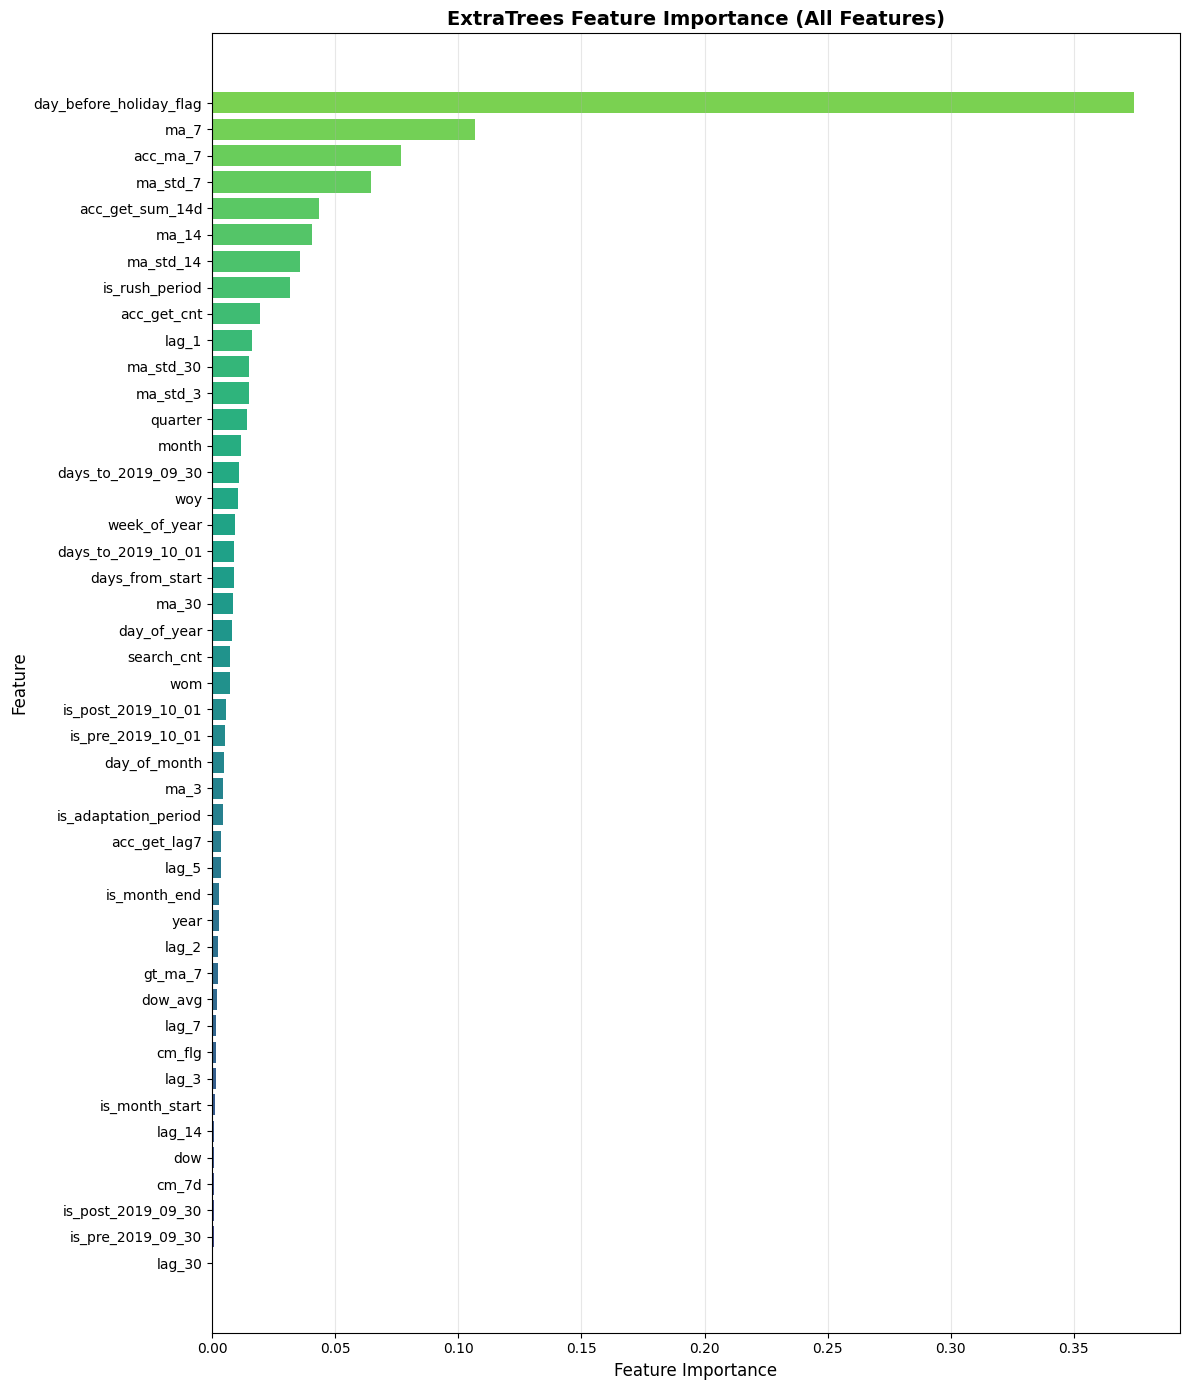


可視化を保存しました: ../output/exp21/extratrees_feature_importance.png
CSVを保存しました: ../output/exp21/extratrees_feature_importance.csv


In [11]:
# ============================================================================
# ExtraTreesの特徴量重要度分析
# ============================================================================

import matplotlib.pyplot as plt

# 特徴量重要度を取得
feature_importances = extra_model.feature_importances_

# DataFrameにまとめる
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# 全特徴量の重要度を表示
print("=" * 80)
print("ExtraTrees 特徴量重要度（全特徴量）")
print("=" * 80)
print(importance_df.to_string(index=False))

# 可視化（全特徴量）
fig, ax = plt.subplots(figsize=(12, 14))

# 重要度順にソート（降順）
importance_sorted = importance_df.sort_values('importance', ascending=True)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_sorted)))

ax.barh(importance_sorted['feature'], importance_sorted['importance'], color=colors)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('ExtraTrees Feature Importance (All Features)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{output_dir}/extratrees_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n可視化を保存しました: {output_dir}/extratrees_feature_importance.png")

# CSVにも保存
importance_df.to_csv(f'{output_dir}/extratrees_feature_importance.csv', index=False)
print(f"CSVを保存しました: {output_dir}/extratrees_feature_importance.csv")

HistGradientBoostingのPermutation Importance計算中...

特徴量重要度（全特徴量）

【ExtraTrees】
                feature  ExtraTrees
day_before_holiday_flag    0.374360
                   ma_7    0.106969
               acc_ma_7    0.076733
               ma_std_7    0.064639
        acc_get_sum_14d    0.043410
                  ma_14    0.040488
              ma_std_14    0.035623
         is_rush_period    0.031505
            acc_get_cnt    0.019650
                  lag_1    0.016167
              ma_std_30    0.015131
               ma_std_3    0.015021
                quarter    0.014034
                  month    0.011580
     days_to_2019_09_30    0.011119
                    woy    0.010683
           week_of_year    0.009202
     days_to_2019_10_01    0.009018
        days_from_start    0.008758
                  ma_30    0.008435
            day_of_year    0.008209
             search_cnt    0.007340
                    wom    0.007319
     is_post_2019_10_01    0.005676
      is_pre_2019_10_0

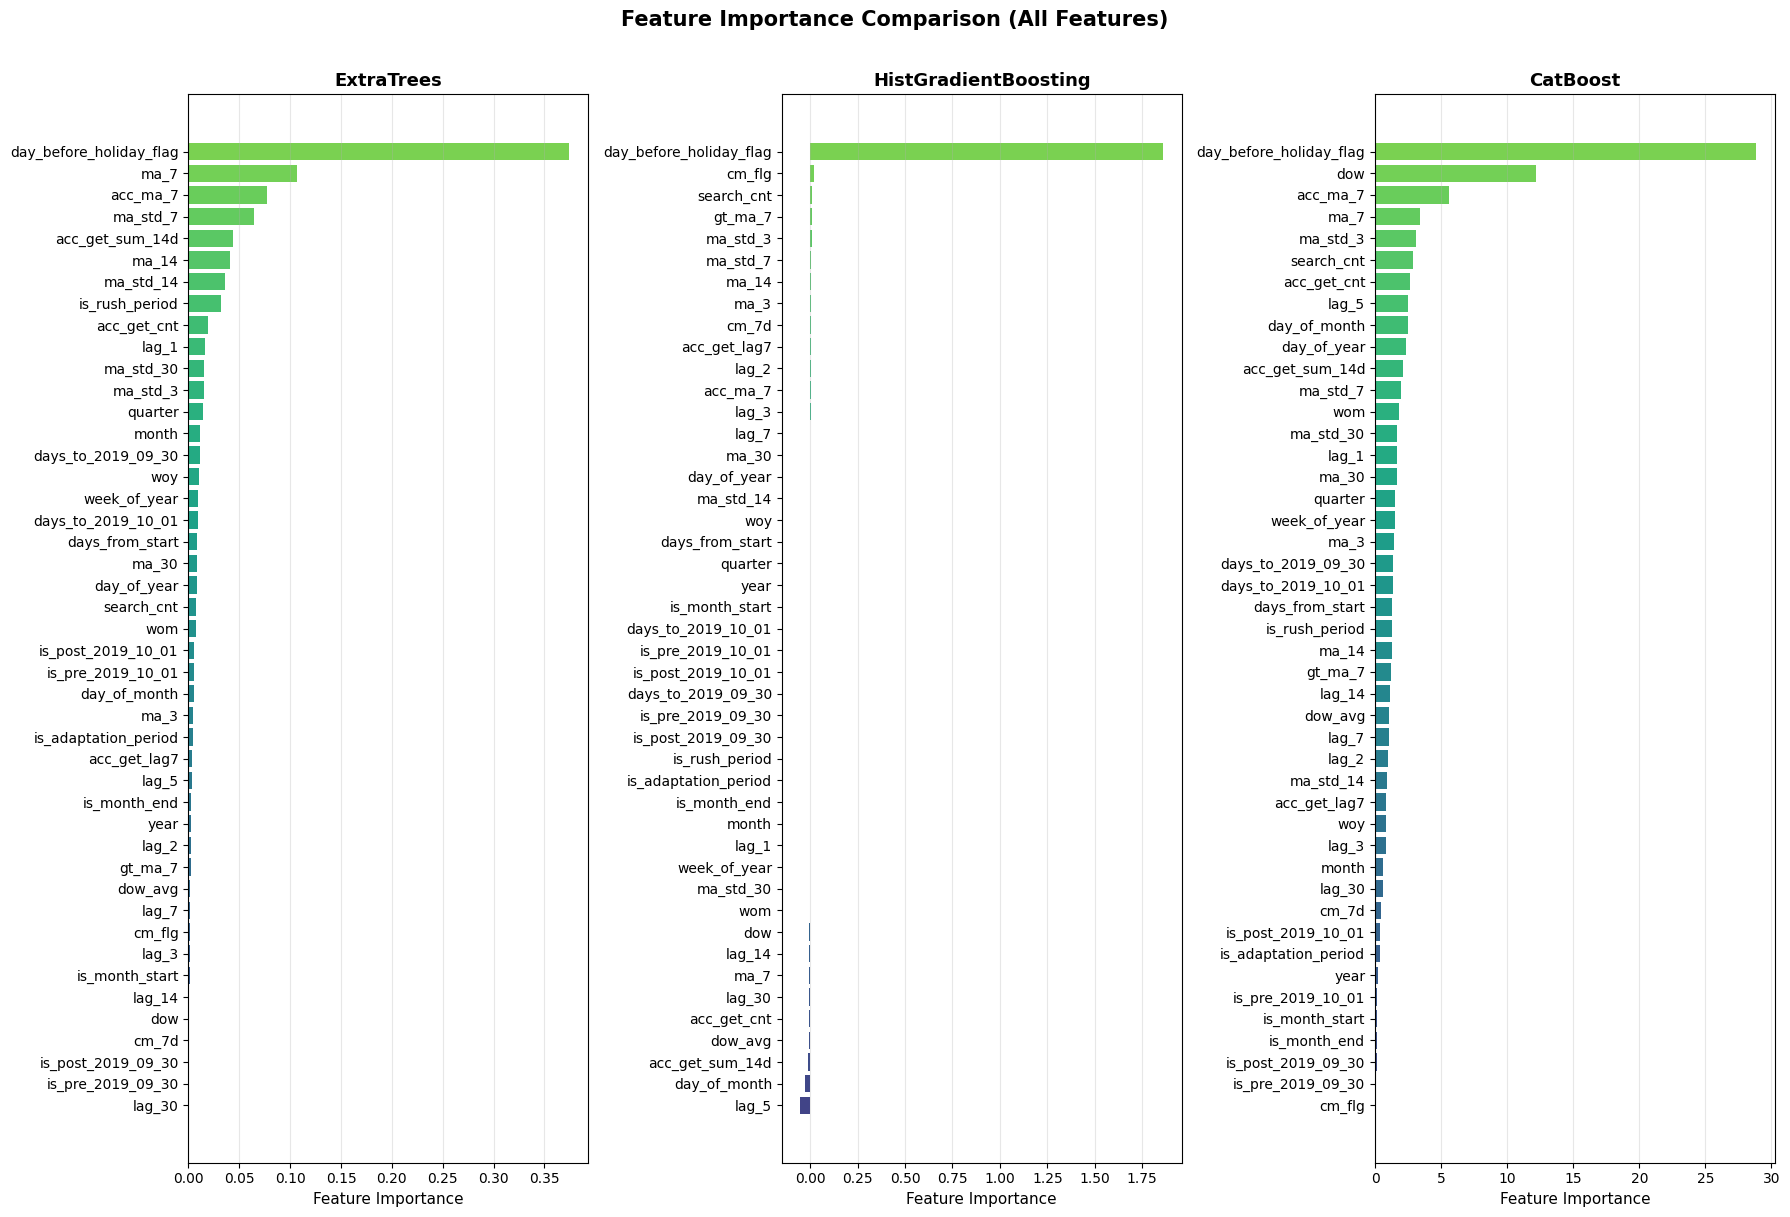


可視化を保存しました: ../output/exp21/all_models_feature_importance.png
CSVを保存しました: ../output/exp21/all_models_feature_importance.csv


In [12]:
# ============================================================================
# 特徴量重要度分析（ExtraTrees, HistGradientBoosting, CatBoost）
# ============================================================================

import matplotlib.pyplot as plt

# 各モデルの特徴量重要度を取得
importance_data = {}

# 1. ExtraTrees
importance_data['ExtraTrees'] = extra_model.feature_importances_

# 2. HistGradientBoosting（permutation importanceではなくfeature_importances_は無いのでNone）
# HistGradientBoostingRegressorはfeature_importances_を持たないため、permutation importanceを使用
from sklearn.inspection import permutation_importance
print("HistGradientBoostingのPermutation Importance計算中...")
perm_importance = permutation_importance(hist_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_data['HistGradientBoosting'] = perm_importance.importances_mean

# 3. CatBoost
importance_data['CatBoost'] = catboost_model.feature_importances_

# DataFrameにまとめる
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'ExtraTrees': importance_data['ExtraTrees'],
    'HistGradientBoosting': importance_data['HistGradientBoosting'],
    'CatBoost': importance_data['CatBoost']
})

# 各モデルの重要度を表示
print("\n" + "=" * 80)
print("特徴量重要度（全特徴量）")
print("=" * 80)

for model_name in ['ExtraTrees', 'HistGradientBoosting', 'CatBoost']:
    print(f"\n【{model_name}】")
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=False)
    print(sorted_df.to_string(index=False))

# 可視化（3モデル並べて表示）
fig, axes = plt.subplots(1, 3, figsize=(18, 12))

for idx, model_name in enumerate(['ExtraTrees', 'HistGradientBoosting', 'CatBoost']):
    ax = axes[idx]
    
    # 重要度順にソート
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=True)
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_df)))
    
    ax.barh(sorted_df['feature'], sorted_df[model_name], color=colors)
    ax.set_xlabel('Feature Importance', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.suptitle('Feature Importance Comparison (All Features)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f'{output_dir}/all_models_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n可視化を保存しました: {output_dir}/all_models_feature_importance.png")

# CSVにも保存
importance_df.to_csv(f'{output_dir}/all_models_feature_importance.csv', index=False)
print(f"CSVを保存しました: {output_dir}/all_models_feature_importance.csv")

高相関ペア（|r| >= 0.8）

高相関ペア数: 51
         feature_1          feature_2  correlation
      week_of_year                woy     1.000000
days_to_2019_10_01 days_to_2019_09_30     1.000000
 is_pre_2019_10_01 is_post_2019_10_01    -1.000000
 is_pre_2019_09_30 is_post_2019_09_30    -1.000000
   days_from_start days_to_2019_10_01    -1.000000
   days_from_start days_to_2019_09_30    -1.000000
             month        day_of_year     0.996634
is_post_2019_10_01  is_pre_2019_09_30    -0.992776
 is_pre_2019_10_01  is_pre_2019_09_30     0.992776
 is_pre_2019_10_01 is_post_2019_09_30    -0.992776
is_post_2019_10_01 is_post_2019_09_30     0.992776
             month            quarter     0.972499
           quarter        day_of_year     0.969203
      day_of_month                wom     0.963512
          acc_ma_7    acc_get_sum_14d     0.959264
       day_of_year       week_of_year     0.958954
       day_of_year                woy     0.958954
             month                woy     0.958867
 

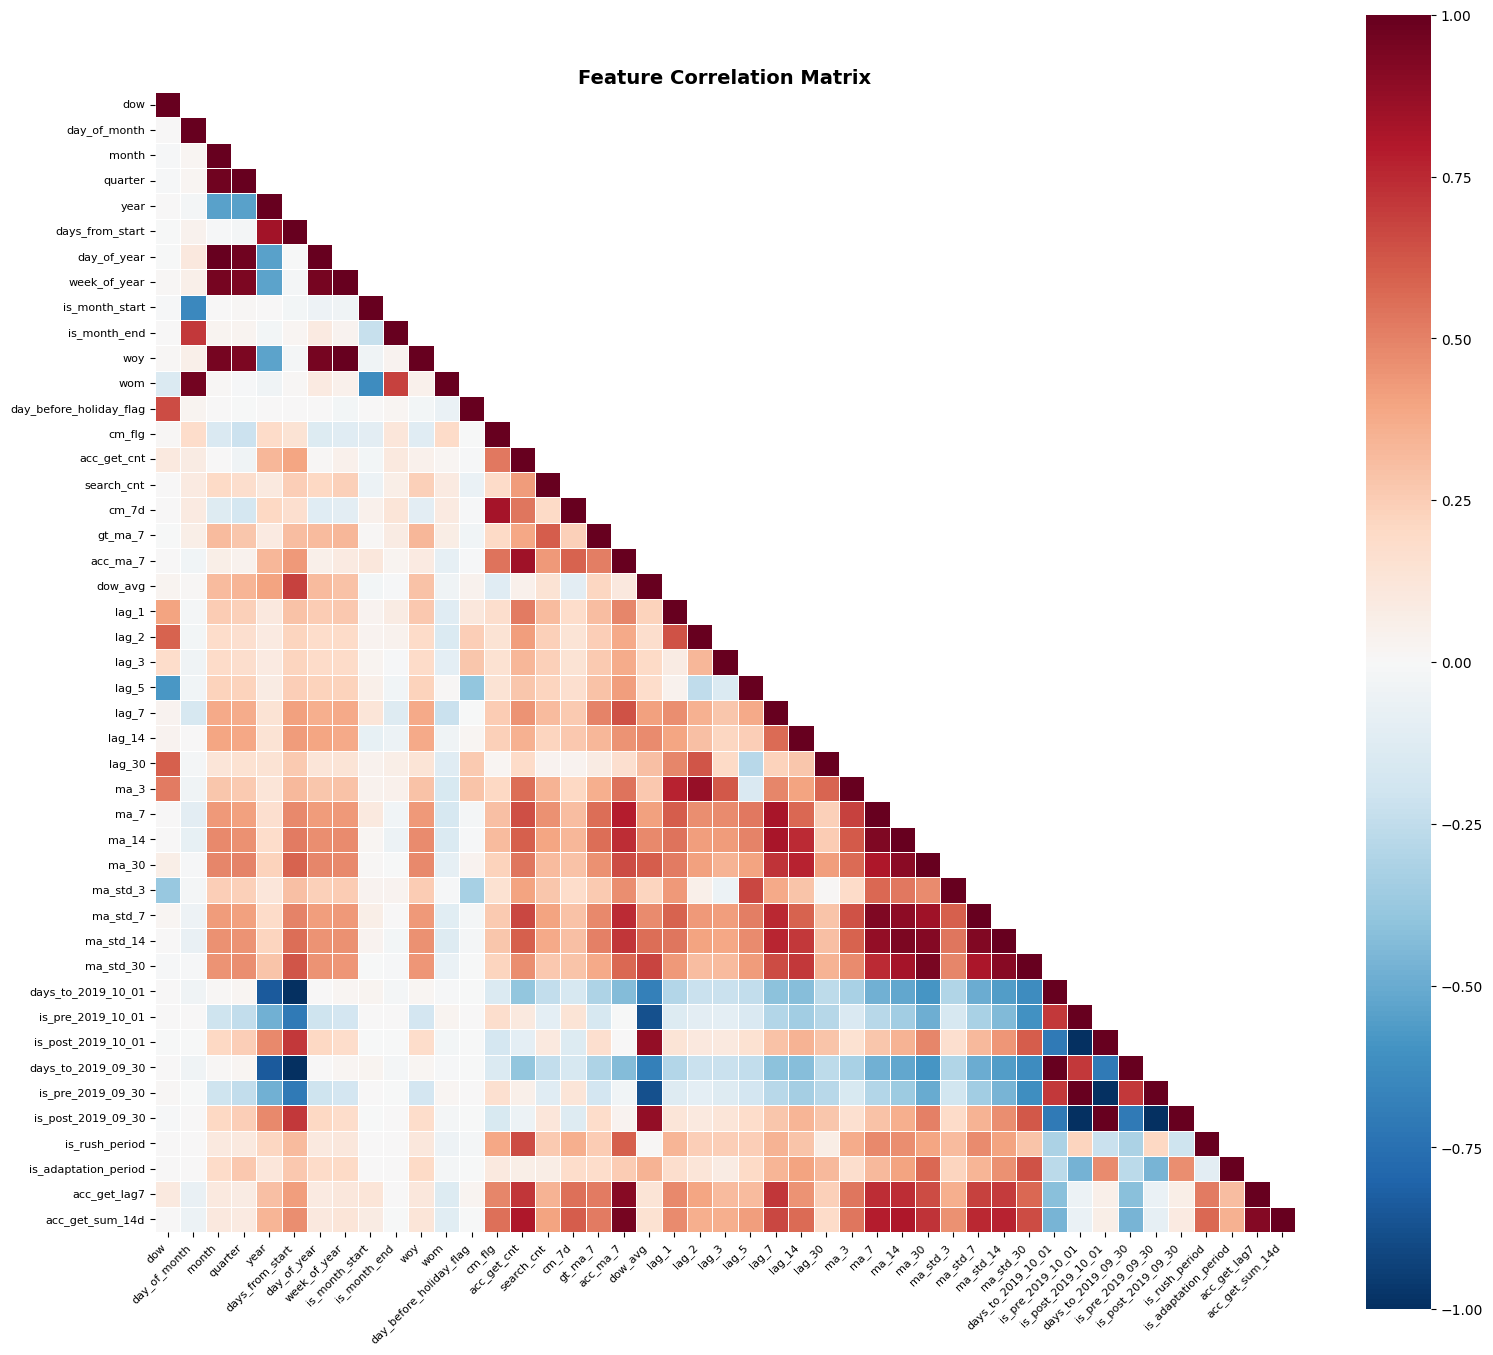


冗長な特徴量グループ

【相関 >= 0.9 のグループ】

グループ1: ['woy', 'week_of_year']
  woy: ExtraTrees=0.0107, CatBoost=0.8299
  week_of_year: ExtraTrees=0.0092, CatBoost=1.5120

グループ2: ['days_from_start', 'days_to_2019_09_30', 'days_to_2019_10_01']
  days_from_start: ExtraTrees=0.0088, CatBoost=1.2823
  days_to_2019_09_30: ExtraTrees=0.0111, CatBoost=1.3854
  days_to_2019_10_01: ExtraTrees=0.0090, CatBoost=1.3623

グループ3: ['is_post_2019_10_01', 'is_pre_2019_10_01']
  is_post_2019_10_01: ExtraTrees=0.0057, CatBoost=0.3467
  is_pre_2019_10_01: ExtraTrees=0.0053, CatBoost=0.1749

グループ4: ['is_post_2019_09_30', 'is_pre_2019_09_30']
  is_post_2019_09_30: ExtraTrees=0.0007, CatBoost=0.1357
  is_pre_2019_09_30: ExtraTrees=0.0006, CatBoost=0.0713

グループ5: ['quarter', 'month', 'day_of_year']
  quarter: ExtraTrees=0.0140, CatBoost=1.5258
  month: ExtraTrees=0.0116, CatBoost=0.6364
  day_of_year: ExtraTrees=0.0082, CatBoost=2.3234

グループ6: ['day_of_month', 'wom']
  day_of_month: ExtraTrees=0.0050, CatBoost=2.4978
  wom: 

In [14]:
# ============================================================================
# 特徴量の冗長性分析（相関性チェック）
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量の相関行列を計算
corr_matrix = X_train[feature_cols].corr()

# 1. 高相関ペアの抽出（|相関係数| >= 0.8）
print("=" * 80)
print("高相関ペア（|r| >= 0.8）")
print("=" * 80)

high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= 0.8:
            high_corr_pairs.append({
                'feature_1': feature_cols[i],
                'feature_2': feature_cols[j],
                'correlation': corr_val
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)
print(f"\n高相関ペア数: {len(high_corr_df)}")
print(high_corr_df.to_string(index=False))

# 2. 相関行列のヒートマップ
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=ax, square=True, linewidths=0.5)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. 冗長な特徴量グループの特定
print("\n" + "=" * 80)
print("冗長な特徴量グループ")
print("=" * 80)

# グループ化（相関0.9以上）
redundant_groups = []
checked = set()

for i, row in high_corr_df[abs(high_corr_df['correlation']) >= 0.9].iterrows():
    f1, f2 = row['feature_1'], row['feature_2']
    if f1 not in checked or f2 not in checked:
        # 既存グループに追加できるか確認
        added = False
        for group in redundant_groups:
            if f1 in group or f2 in group:
                group.add(f1)
                group.add(f2)
                added = True
                break
        if not added:
            redundant_groups.append({f1, f2})
        checked.add(f1)
        checked.add(f2)

print("\n【相関 >= 0.9 のグループ】")
for i, group in enumerate(redundant_groups, 1):
    print(f"\nグループ{i}: {list(group)}")
    # グループ内の特徴量重要度を表示
    for feat in group:
        ext_imp = importance_df[importance_df['feature'] == feat]['ExtraTrees'].values[0]
        cat_imp = importance_df[importance_df['feature'] == feat]['CatBoost'].values[0]
        print(f"  {feat}: ExtraTrees={ext_imp:.4f}, CatBoost={cat_imp:.4f}")

# 4. 削除候補の特定
print("\n" + "=" * 80)
print("削除候補の特徴量")
print("=" * 80)

delete_candidates = []
for group in redundant_groups:
    group_list = list(group)
    # 重要度が最も高いものを残し、他を削除候補に
    best_feat = max(group_list, key=lambda f: importance_df[importance_df['feature'] == f]['ExtraTrees'].values[0])
    for feat in group_list:
        if feat != best_feat:
            ext_imp = importance_df[importance_df['feature'] == feat]['ExtraTrees'].values[0]
            delete_candidates.append({
                'feature': feat,
                'reason': f'高相関（{best_feat}と冗長）',
                'importance': ext_imp
            })

# 重要度が非常に低い特徴量も候補に
low_importance_threshold = 0.01
for feat in feature_cols:
    ext_imp = importance_df[importance_df['feature'] == feat]['ExtraTrees'].values[0]
    if ext_imp < low_importance_threshold and feat not in [d['feature'] for d in delete_candidates]:
        delete_candidates.append({
            'feature': feat,
            'reason': '重要度が非常に低い',
            'importance': ext_imp
        })

delete_df = pd.DataFrame(delete_candidates).sort_values('importance')
print(f"\n削除候補数: {len(delete_df)}")
print(delete_df.to_string(index=False))

# CSVに保存
high_corr_df.to_csv(f'{output_dir}/high_correlation_pairs.csv', index=False)
delete_df.to_csv(f'{output_dir}/delete_candidates.csv', index=False)
print(f"\n保存しました:")
print(f"  {output_dir}/high_correlation_pairs.csv")
print(f"  {output_dir}/delete_candidates.csv")